# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [2]:
print('Выведем первые 5 строк датасета:')
display(data.head())

print('\nПосмотрим на описательные статистики:')
display(data.describe())

print('\nПроверим типы данных и наличие NaN-значений:')
display(data.info())

print('Количество дубликатов в датасете:', data.duplicated().sum())

print('\nКоличество пользователей на каждом тарифе:')
print(data.is_ultra.value_counts())

Выведем первые 5 строк датасета:


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0



Посмотрим на описательные статистики:


,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000



Проверим типы данных и наличие NaN-значений:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


None

Количество дубликатов в датасете: 0

Количество пользователей на каждом тарифе:
0    2229
1     985
Name: is_ultra, dtype: int64


### Проверим корреляцию признаков

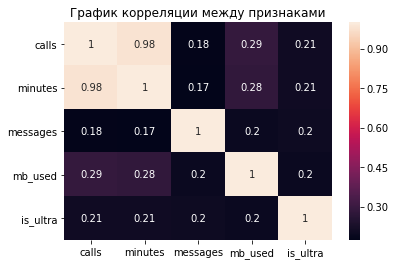

In [3]:
sns.heatmap(data.corr(), annot=True)
plt.title('График корреляции между признаками')
plt.show()

**Вывод:** В датасете действительно наблюдается корреляция между звонками и минутами. Ниже попробуем избавиться от столбца со звонками и посмотрим что это даст в модели. По-сути, столбец с количеством звонков вообще не несет какой-либо ценности в данном проекте, так что можем избавиться от него в любом случае.

In [4]:
data = data.drop(columns='calls')

В остальном данные представляются мне вполне годными для работы.

## Разбейте данные на выборки

In [5]:
# Разделим данные на выборки в соотношении 60, 20, 20
data_train, data_temp = train_test_split(data, train_size=0.6, random_state=12345, stratify=data.is_ultra)
data_valid, data_test = train_test_split(data_temp, train_size=0.5, random_state=12345, stratify=data_temp.is_ultra)

# Выделим признаки и цели
features_train = data_train.drop(columns='is_ultra')
features_valid = data_valid.drop(columns='is_ultra')
features_test = data_test.drop(columns='is_ultra')
target_train = data_train.is_ultra
target_valid = data_valid.is_ultra
target_test = data_test.is_ultra

print('Размер обучающей выборки:', features_train.shape, target_train.shape)
print('Размер валидационной выборки:', features_valid.shape, target_valid.shape)
print('Размер тестовой выборки:', features_test.shape, target_test.shape)

Размер обучающей выборки: (1928, 3) (1928,)
Размер валидационной выборки: (643, 3) (643,)
Размер тестовой выборки: (643, 3) (643,)


## Исследуйте модели

Проверять будем три модели: Дерево решений, Случайный лес и Логистическую регрессию

In [6]:
models = [DecisionTreeClassifier, RandomForestClassifier, LogisticRegression]
best_model = None
best_result = 0

# Проверим качество моделей в цикле
for model in models:
    if model == DecisionTreeClassifier:
        for depth in range(1, 11):
            model = DecisionTreeClassifier(max_depth=depth, random_state=12345) # Дерево решений
            model.fit(features_train, target_train)
            result = model.score(features_valid, target_valid)
            
            if result > best_result:
                best_model = model
                best_result = result
            
    elif model == RandomForestClassifier:
        for depth in range(1, 11):
            for estimators in range(10, 30,):
                model = RandomForestClassifier(random_state=12345, n_estimators=estimators, max_depth=depth) # Случайный лес
                model.fit(features_train, target_train)
                result = model.score(features_valid, target_valid)
            
                if result > best_result:
                    best_model = model
                    best_result = result
                
    else:
        model = LogisticRegression(random_state=12345, solver='lbfgs') # Логистическая регрессия
        model.fit(features_train, target_train) 
        result = model.score(features_valid, target_valid)
        
        if result > best_result:
                best_model = model
                best_result = result

In [7]:
print('Лучшая модель:', best_model)
print('Лучший результат', best_result.round(3))

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=23,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)
Лучший результат 0.815


Как мы видим, лучшей моделью оказался **Случайный лес** в **21** дерево глубиной **10**

## Проверьте модель на тестовой выборке

In [8]:
# Добавим валидационную выборку в обучающую для улучшения качества обучения
features_train = features_train.append(features_valid)
target_train = target_train.append(target_valid)
best_model.fit(features_train, target_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=23,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

In [9]:
predictions_test = best_model.predict(features_test)
best_score = accuracy_score(target_test, predictions_test)
print('Точность модели на тестовой выборке:', best_score.round(3))

Точность модели на тестовой выборке: 0.838


## (бонус) Проверьте модели на адекватность

Для проверки модели на адекватность предположим, что мы создали дамми-модель, которая рекомендует тариф Смарт всем пользователям.

In [10]:
dummy = DummyClassifier(strategy='most_frequent', random_state=0).fit(features_train, target_train)
dummy.score(features_test, target_test)

0.6936236391912908

Точность дамми-модели составила 69%, наша модель выдает 83.8% - тест на адекватность сдан!

## Вывод

Для системы рекомендаций тарифов была построена модель Случайного леса размером в 23 дерева, обладающая точностью в **83.8%**. 

Точность рекомендаций не очень высока, но вполне приемлема для начального этапа работы системы. С ростом объема данных точность модели будет расти